# Quantifying Classification Uncertainty in Deep Neural Networks

The purpose of this page is to provide an easy-to-run demo with low computational requirements for the ideas proposed in the paper _Evidential Deep Learning to Quantify Classification Uncertainty_. Using MNIST dataset, I demonstrate how to create neural networks that are able to quantify classification uncertainty. The paper can be accesed over http://arxiv.org/abs/1806.01768

You can run this notebook in Colab using the colab icon below: 


<a href="https://colab.research.google.com/github/muratsensoy/muratsensoy.github.io/blob/master/uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook can also be downloaded using https://muratsensoy.github.io/uncertainty.ipynb

#  Neural Networks Trained with Softmax Cross Entropy Loss

The following lines of codes demonstrate how softmax based Deep Neural Networks fail when they encounter out-of-sample queries.

In [1]:
# use this while running this notebook in Colab
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [1]:
#import necessary libraries
import tensorflow as tf
import numpy as np
!pip install scipy
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl
from IPython import display

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Download MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

K= 10 # number of classes

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [28]:
# Model / data parameters
num_classes = 10
K = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train =  tf.image.rgb_to_grayscale(x_train, name=None)
x_test =  tf.image.rgb_to_grayscale(x_test, name=None)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 1)
50000 train samples
10000 test samples


NotImplementedError: Cannot convert a symbolic Tensor (strided_slice_11:0) to a numpy array.

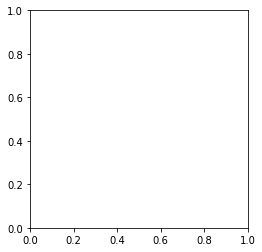

In [44]:
plt.imshow(x_train[0])

In [4]:
digit_one = mnist.train.images[4].copy()
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

NameError: name 'mnist' is not defined

In [5]:
# define some utility functions
def var(name, shape, init=None):
    if init is None:
        init = tf.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=init)

def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(Xin, f, strides, padding)

def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(Xin, ksize, strides, padding)

def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()

In [6]:
# Create a LeNet network with softmax cross entropy loss function
def LeNet_softmax(lmb=0.005): 
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
        keep_prob = tf.placeholder(dtype=tf.float32)
        
        # first hidden layer - conv
        W1 = var('W1', [5,5,1,20])
        b1 = var('b1', [20])
        out1 = max_pool(tf.nn.relu(conv(tf.reshape(X, [-1, 28,28, 1]), 
                                        W1, strides=[1, 1, 1, 1]) + b1))
        # second hidden layer - conv
        W2 = var('W2', [5,5,20,50])
        b2 = var('b2', [50])
        out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
        # flatten the output
        Xflat = tf.contrib.layers.flatten(out2)
        # third hidden layer - fully connected
        W3 = var('W3', [Xflat.get_shape()[1].value, 500])
        b3 = var('b3', [500]) 
        out3 = tf.nn.relu(tf.matmul(Xflat, W3) + b3)
        out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        #output layer
        W4 = var('W4', [500,10])
        b4 = var('b4',[10])
        logits = tf.matmul(out3, W4) + b4
        
        prob = tf.nn.softmax(logits=logits) 
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
        l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
        
        step = tf.train.AdamOptimizer().minimize(loss + l2_loss)
        
        # Calculate accuracy
        pred = tf.argmax(logits, 1)
        truth = tf.argmax(Y, 1)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred, truth), tf.float32))
        
        return g, step, X, Y, keep_prob, prob, acc, loss

In [7]:
# get the LeNet network
g1, step1, X1, Y1, keep_prob1, prob1, acc1, loss1 = LeNet_softmax()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
sess1 = tf.Session(graph=g1)
with g1.as_default(): 
    sess1.run(tf.global_variables_initializer())

In [8]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X1:data, Y1:label, keep_prob1:.5}
        sess1.run(step1,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc = sess1.run(acc1, feed_dict={X1:mnist.train.images,Y1:mnist.train.labels,keep_prob1:1.})
    test_acc = sess1.run(acc1, feed_dict={X1:mnist.test.images,Y1:mnist.test.labels,keep_prob1:1.})
    
    print('training accuracy: %2.4f \t testing accuracy: %2.4f' % (train_acc, test_acc))

epoch 1 - 100%) training accuracy: 0.9182 	 testing accuracy: 0.9234
epoch 2 - 100%) training accuracy: 0.9541 	 testing accuracy: 0.9545
epoch 3 - 100%) training accuracy: 0.9650 	 testing accuracy: 0.9654
epoch 4 - 100%) training accuracy: 0.9737 	 testing accuracy: 0.9737
epoch 5 - 100%) training accuracy: 0.9767 	 testing accuracy: 0.9749
epoch 6 - 100%) training accuracy: 0.9794 	 testing accuracy: 0.9770
epoch 7 - 100%) training accuracy: 0.9812 	 testing accuracy: 0.9786
epoch 8 - 100%) training accuracy: 0.9834 	 testing accuracy: 0.9809
epoch 9 - 100%) training accuracy: 0.9848 	 testing accuracy: 0.9805
epoch 10 - 100%) training accuracy: 0.9866 	 testing accuracy: 0.9825
epoch 11 - 100%) training accuracy: 0.9876 	 testing accuracy: 0.9841
epoch 12 - 100%) training accuracy: 0.9873 	 testing accuracy: 0.9834


KeyboardInterrupt: 

The test accuracy after 50 epochs is around 98.9%. Now, we want to classify a rotating digit from MNIST dataset to see how this network does for the samples that are not from the training set distribution. The following lines of codes helps us to see it.

In [8]:
# This method rotates an image counter-clockwise and classify it for different degress of rotation. 
# It plots the highest classification probability along with the class label for each rotation degree.
def rotating_image_classification(img, sess, prob, X, keep_prob, uncertainty=None, threshold=0.5):
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    rimgs = np.zeros((28,28*Ndeg))
    for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
        nimg = rotate_img(img,deg).reshape(28,28)
        nimg = np.clip(a=nimg,a_min=0,a_max=1)
        rimgs[:,i*28:(i+1)*28] = nimg
        feed_dict={X:nimg.reshape(1,-1), keep_prob:1.0}
        if uncertainty is None:
            p_pred_t = sess.run(prob, feed_dict=feed_dict)
        else:
            p_pred_t,u = sess.run([prob,uncertainty], feed_dict=feed_dict)
            lu.append(u.mean())
        scores += p_pred_t >= threshold
        ldeg.append(deg) 
        lp.append(p_pred_t[0])
    
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels", labels)
    lp = np.array(lp)[:,labels]
    c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*2
    labels = labels.tolist()
    for i in range(len(labels)):
        print("lp",lp[:,i])
        plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])
    
    if uncertainty is not None:
        labels += ['uncertainty']
        plt.plot(ldeg,lu,marker='<',c='red')
        
    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

labels [4 5 7 9]
lp [8.8782364e-01 9.4841045e-01 9.9734336e-01 9.2356306e-01 4.6143599e-02
 2.9805508e-01 1.8684766e-01 7.0509888e-02 3.9381669e-03 2.7115484e-05
 6.8888345e-05 6.3766456e-06 1.9647956e-03 3.5944683e-03 1.5144859e-01
 2.4680020e-01 6.0950923e-01 6.6565639e-01 1.2088924e-01]
lp [2.3098092e-04 8.5448519e-05 5.5674459e-06 4.0903926e-02 6.8377680e-01
 2.7759317e-01 3.1821798e-03 1.0093792e-03 1.7274309e-05 1.6558273e-08
 2.5114352e-07 7.2464502e-08 2.8984840e-07 9.3839967e-09 1.7341416e-06
 4.7414557e-07 2.5479241e-07 4.8057464e-06 1.9123649e-05]
lp [0.03430312 0.01681698 0.00106239 0.00729344 0.25914088 0.1776958
 0.060839   0.4138749  0.87100714 0.9948084  0.91062635 0.96584076
 0.9400759  0.85925055 0.6743678  0.65020865 0.01801613 0.05922282
 0.4632152 ]
lp [6.6015177e-04 4.7514203e-04 6.6534390e-05 1.7393306e-02 1.0782457e-02
 2.2031911e-01 7.3639458e-01 4.1541153e-01 1.4756736e-02 4.9921998e-04
 1.0968171e-04 2.1616102e-03 5.1724439e-04 6.6667685e-04 1.3761465e-03
 7.

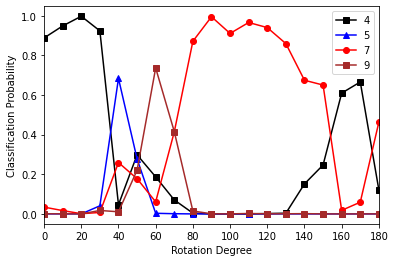

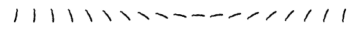

In [10]:
rotating_image_classification(digit_one, sess1, prob1, X1, keep_prob1)

As shown above, a neural network trained to generate softmax probabilities fails significantly when it encounters a sample that is different from the training examples. The softmax forces neural network to pick one class, even though the object belongs to an unknown category. This is demonstrated when we rotate the digit one between 60 and 130 degrees. 

# Classification with Evidential Deep Learning

In the following sections, we train the same neural network using the loss functions introduced in the paper.

## Using the Expected Mean Square Error (Eq. 5)

As described in the paper, a neural network can be trained to learn parameters of a Dirichlet distribution, instead of softmax probabilities. Dirichlet distributions with parameters $\alpha \geq 1$ behaves like a generative model for softmax probabilities (categorical distributions). It associates a likelihood value with each categorical distribution.

## Some functions to convert logits to evidence

In [9]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

## Define the loss function

In [10]:
def KL(alpha):
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keep_dims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keep_dims=True)
    lnB = tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keep_dims=True)
    lnB_uni = tf.reduce_sum(tf.lgamma(beta),axis=1,keep_dims=True) - tf.lgamma(S_beta)
    
    dg0 = tf.digamma(S_alpha)
    dg1 = tf.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keep_dims=True) + lnB + lnB_uni
    return kl

def mse_loss(p, alpha, global_step, annealing_step): 
    S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
    E = alpha - 1
    m = alpha / S
    
    A = tf.reduce_sum((p-m)**2, axis=1, keep_dims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keep_dims=True) 
    
    annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
#     annealing_coef = .2
    alp = E*(1-p) + 1 
    C = annealing_coef * KL(alp)
    # C = 0.01* KL(alp)
    return (A + B) + C

In [40]:
# train LeNet network with expected mean square error loss
def LeNet_EDL(logits2evidence=relu_evidence,loss_function=mse_loss, lmb=0.005):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,32,32], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
        keep_prob = tf.placeholder(dtype=tf.float32)
        global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
        annealing_step = tf.placeholder(dtype=tf.int32) 
    
        # first hidden layer - conv
        W1 = var('W1', [5,5,1,20])
        b1 = var('b1', [20])
        out1 = max_pool(tf.nn.relu(conv(tf.reshape(X, [-1, 32,32, 1]), 
                                        W1, strides=[1, 1, 1, 1]) + b1))
        # second hidden layer - conv
        W2 = var('W2', [5,5,20,50])
        b2 = var('b2', [50])
        out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
        # flatten the output
        Xflat = tf.contrib.layers.flatten(out2)
        # third hidden layer - fully connected
        W3 = var('W3', [Xflat.get_shape()[1].value, 500])
        b3 = var('b3', [500]) 
        out3 = tf.nn.relu(tf.matmul(Xflat, W3) + b3)
        out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        #output layer
        W4 = var('W4', [500,10])
        b4 = var('b4',[10])
        logits = tf.matmul(out3, W4) + b4
        
        evidence = logits2evidence(logits)
        alpha = evidence + 1
        
        u = K / tf.reduce_sum(alpha, axis=1, keep_dims=True) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
#         tf.print("u ", tf.reduce_sum(prob))
        loss = tf.reduce_mean(loss_function(Y, alpha, global_step, annealing_step))
        l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
        
        step = tf.train.AdamOptimizer().minimize(loss + l2_loss, global_step=global_step)
        print(global_step)
        # Calculate accuracy
        pred = tf.argmax(logits, 1)
        truth = tf.argmax(Y, 1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        acc = tf.reduce_mean(match)
        
        total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
        mean_ev = tf.reduce_mean(total_evidence)
        mean_ev_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
        mean_ev_fail = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
        print("test")
        return g, step, X, Y, annealing_step, keep_prob, prob, acc, loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail,global_step

In [41]:
g2, step2, X2, Y2, annealing_step, keep_prob2, prob2, acc2, loss2, u, evidence, \
    mean_ev, mean_ev_succ, mean_ev_fail, global_step= LeNet_EDL()
print(global_step)

<tf.Variable 'global_step:0' shape=() dtype=int32_ref>
test
<tf.Variable 'global_step:0' shape=() dtype=int32_ref>


In [50]:
sess2 = tf.Session(graph=g2)
with g2.as_default():
    sess2.run(tf.global_variables_initializer())

x_train shape: (50000, 32, 32, 1)
50000 train samples
10000 test samples


In [51]:
bsize = 1000 #batch size
# n_batches = len(x_train) // bsize
L_train_acc1=[]
L_train_ev_s=[]
L_train_ev_f=[]
L_test_acc1=[]
L_test_ev_s=[]
L_test_ev_f=[]
for epoch in range(50):  
    for i in range(45000):
        data, label = x_train[i], y_train[i]
        with g2.as_default():
            print(data.eval())
#         print(data)
#         data = np.reshape(data,[1024])
        feed_dict={X2:data, Y2:label, keep_prob2:.5, annealing_step:10*n_batches}
        sess2.run(step2,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail,gstep = sess2.run([acc2,mean_ev_succ,mean_ev_fail,global_step], feed_dict={X2:mnist.train.images,Y2:mnist.train.labels,keep_prob2:1.})
    test_acc, test_succ, test_fail = sess2.run([acc2,mean_ev_succ,mean_ev_fail], feed_dict={X2:mnist.test.images,Y2:mnist.test.labels,keep_prob2:1.})
    print("g",gstep)
    L_train_acc1.append(train_acc)
    L_train_ev_s.append(train_succ)
    L_train_ev_f.append(train_fail)
    
    L_test_acc1.append(test_acc)
    L_test_ev_s.append(test_succ)
    L_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [ ]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L_train_acc1=[]
L_train_ev_s=[]
L_train_ev_f=[]
L_test_acc1=[]
L_test_ev_s=[]
L_test_ev_f=[]
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X2:data, Y2:label, keep_prob2:.5, annealing_step:10*n_batches}
        sess2.run(step2,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail,gstep = sess2.run([acc2,mean_ev_succ,mean_ev_fail,global_step], feed_dict={X2:mnist.train.images,Y2:mnist.train.labels,keep_prob2:1.})
    test_acc, test_succ, test_fail = sess2.run([acc2,mean_ev_succ,mean_ev_fail], feed_dict={X2:mnist.test.images,Y2:mnist.test.labels,keep_prob2:1.})
    print("g",gstep)
    L_train_acc1.append(train_acc)
    L_train_ev_s.append(train_succ)
    L_train_ev_f.append(train_fail)
    
    L_test_acc1.append(test_acc)
    L_test_ev_s.append(test_succ)
    L_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

epoch 1 - 100%) g 455
training: 0.9816 (38.1174 - 2.5073) 	 testing: 0.9835 (38.7442 - 3.3183)
epoch 2 - 100%) g 510
training: 0.9831 (40.4025 - 2.7234) 	 testing: 0.9842 (41.3063 - 3.8998)
epoch 3 - 100%) g 565
training: 0.9835 (41.3323 - 2.9105) 	 testing: 0.9838 (42.3154 - 4.1256)
epoch 4 - 100%) g 620
training: 0.9837 (41.1301 - 1.9959) 	 testing: 0.9842 (41.8369 - 2.7323)
epoch 5 - 100%) g 675
training: 0.9843 (40.6055 - 1.8911) 	 testing: 0.9857 (41.3153 - 3.0321)
epoch 6 - 100%) 

The following function plots average total evidence and prediction uncertainty in addition to accuracy for the training and test sets. Let us note that uncertainty approaches to 1.0 as the total evidence approaches to 0.

In [51]:
def draw_EDL_results(train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f): 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    train_u_succ = K / (K+np.array(train_ev_s))
    train_u_fail = K / (K+np.array(train_ev_f))
    test_u_succ  = K / (K+np.array(test_ev_s))
    test_u_fail  = K / (K+np.array(test_ev_f))
    
    f, axs = pl.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(train_ev_s,c='r',marker='+')
    axs[0,0].plot(train_ev_f,c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(train_acc1,c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(test_ev_s,c='r',marker='+')
    axs[1,0].plot(test_ev_f,c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(test_acc1,c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    plt.show()

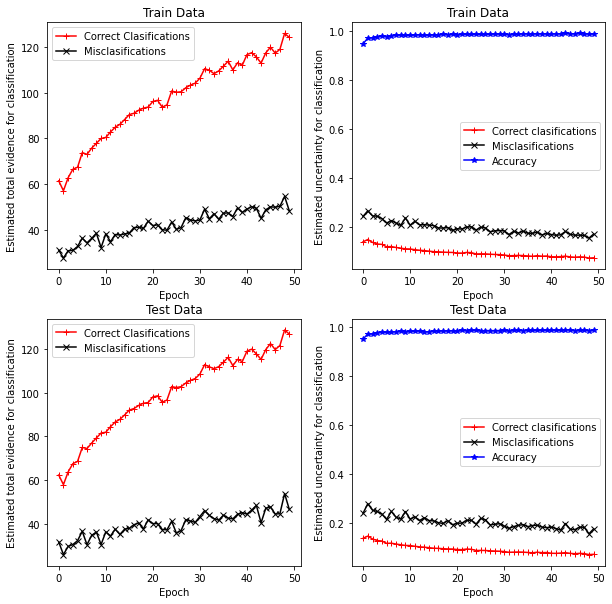

In [52]:
draw_EDL_results(L_train_acc1, L_train_ev_s, L_train_ev_f, L_test_acc1, L_test_ev_s, L_test_ev_f)

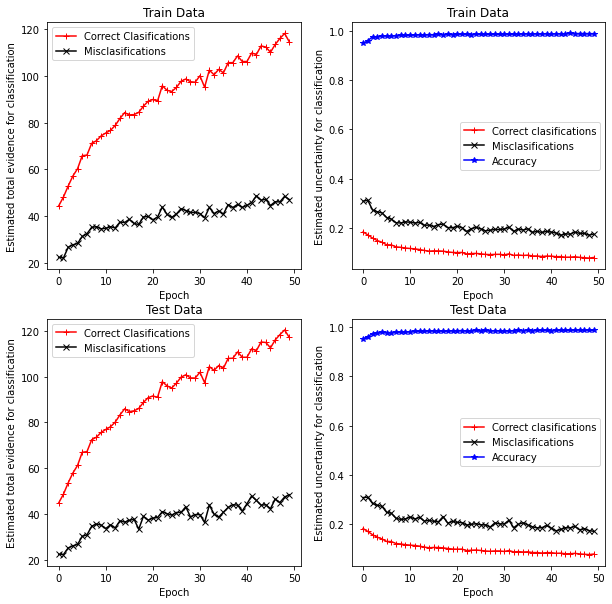

In [42]:
draw_EDL_results(L_train_acc1, L_train_ev_s, L_train_ev_f, L_test_acc1, L_test_ev_s, L_test_ev_f)

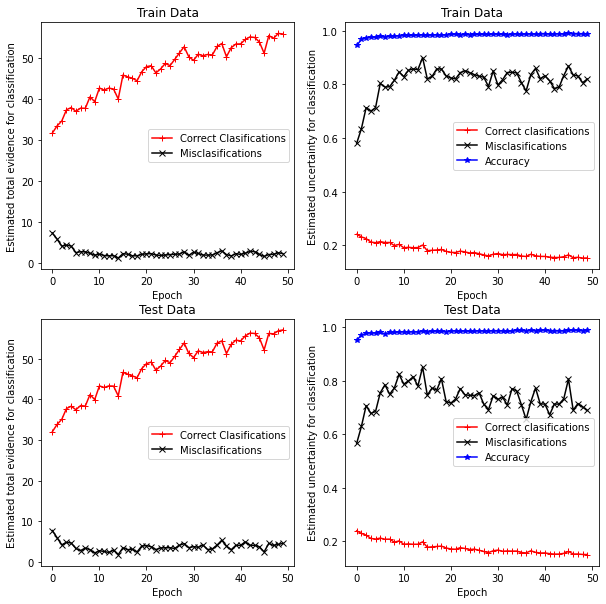

In [21]:
draw_EDL_results(L_train_acc1, L_train_ev_s, L_train_ev_f, L_test_acc1, L_test_ev_s, L_test_ev_f)

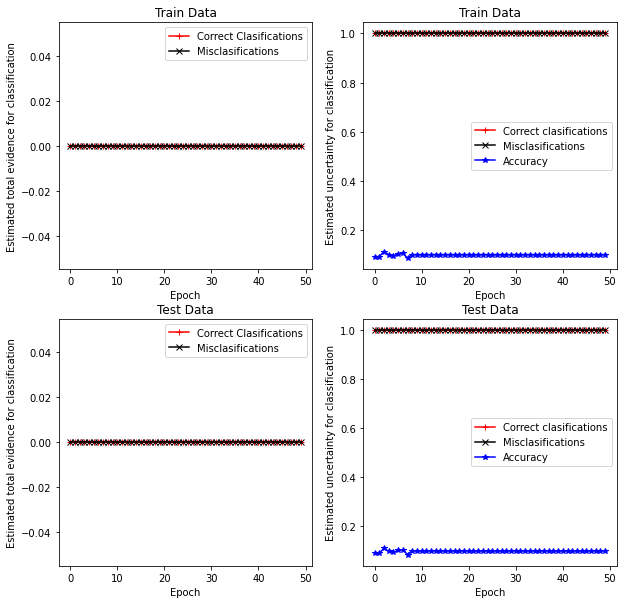

In [43]:
#new
draw_EDL_results(L_train_acc1, L_train_ev_s, L_train_ev_f, L_test_acc1, L_test_ev_s, L_test_ev_f)

The figure above indicates that the proposed approach generates much smaller amount of evidence for the misclassified samples than the correctly classified ones. The uncertainty of the misclassified samples are around 0.8, while it is around 0.1 for the correctly classified ones, both for training and testing sets. This means that the neural network is very uncertain for the misclassified samples and provides certain predictions only for the correctly classified ones. In other words, the neural network also predicts when it fails by assigning high uncertainty to its wrong predictions.

In [53]:
def rotating_image_classification(img, sess, prob, X, keep_prob, uncertainty=None, threshold=0.5):
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    rimgs = np.zeros((28,28*Ndeg))
    for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
        nimg = rotate_img(img,deg).reshape(28,28)
        nimg = np.clip(a=nimg,a_min=0,a_max=1)
        rimgs[:,i*28:(i+1)*28] = nimg
        feed_dict={X:nimg.reshape(1,-1), keep_prob:1.0}
#         print("uncert", uncertainty)
        if uncertainty is None:
            p_pred_t = sess.run(prob, feed_dict=feed_dict)
        else:
            p_pred_t,u = sess.run([prob,uncertainty], feed_dict=feed_dict)
            lu.append(u.mean())
        print(p_pred_t, u.mean())
        scores += p_pred_t >= threshold
        ldeg.append(deg) 
        lp.append(p_pred_t[0])
            
        # print(pred, np.argmax(pred))
#         _ = plt.imshow(nimg)
#         plt.show()
    
    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:,labels]
    c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*2
    labels = labels.tolist()
    for i in range(len(labels)):
        plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])
    
    if uncertainty is not None:
        labels += ['uncertainty']
        plt.plot(ldeg,lu,marker='<',c='red')
        
    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

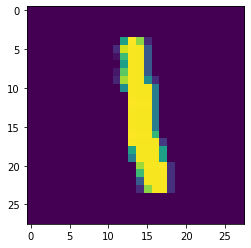

In [54]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
plt.imshow(x_train[6].reshape(28,28))
plt.show()

Tensor("truediv:0", shape=(?, 1), dtype=float32)
[[0.00868058 0.92187476 0.00868058 0.00868058 0.00868058 0.00868058
  0.00868058 0.00868058 0.00868058 0.00868058]] 0.08680581
[[0.0380147  0.21711183 0.28758925 0.13698387 0.0380147  0.0380147
  0.0380147  0.0380147  0.1302269  0.0380147 ]] 0.38014695
[[0.03288542 0.03288542 0.4551038  0.28181282 0.03288542 0.03288542
  0.03288542 0.03288542 0.03288542 0.03288542]] 0.3288542
[[0.02708424 0.02708424 0.5357996  0.24752644 0.02708424 0.02708424
  0.02708424 0.02708424 0.02708424 0.02708424]] 0.27084237
[[0.02349121 0.02349121 0.5877475  0.22432283 0.02349121 0.02349121
  0.02349121 0.02349121 0.02349121 0.02349121]] 0.2349121
[[0.0333455 0.0333455 0.6998905 0.0333455 0.0333455 0.0333455 0.0333455
  0.0333455 0.0333455 0.0333455]] 0.333455
[[0.03350818 0.03350818 0.3719877  0.03350818 0.03350818 0.03350818
  0.03350818 0.3599469  0.03350818 0.03350818]] 0.33508176
[[0.04099735 0.04099735 0.07060646 0.04099735 0.04099735 0.04099735
  0.04099

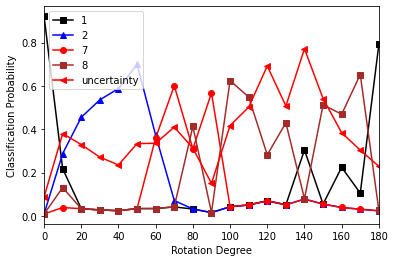

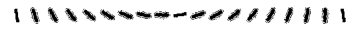

In [55]:
print(u)
rotating_image_classification(x_train[6], sess2, prob2, X2, keep_prob2, u)

Tensor("truediv:0", shape=(?, 1), dtype=float32)
[[0.00801611 0.927855   0.00801611 0.00801611 0.00801611 0.00801611
  0.00801611 0.00801611 0.00801611 0.00801611]] 0.080161095
[[0.02552026 0.3588471  0.02552026 0.02552026 0.02552026 0.02552026
  0.02552026 0.02552026 0.43699083 0.02552026]] 0.25520256
[[0.04814115 0.10628518 0.18028364 0.04814115 0.04814115 0.04814115
  0.04814115 0.04814115 0.37644315 0.04814115]] 0.48141152
[[0.02914618 0.02914618 0.3638411  0.02914618 0.02914618 0.02914618
  0.02914618 0.02914618 0.40298948 0.02914618]] 0.29146183
[[0.03192231 0.03192231 0.49974358 0.03192231 0.03192231 0.03192231
  0.03192231 0.03192231 0.2448779  0.03192231]] 0.3192231
[[0.04948271 0.04948271 0.04948271 0.04948271 0.04948271 0.04948271
  0.04948271 0.04948271 0.5546556  0.04948271]] 0.49482712
[[0.04113236 0.04113236 0.04113236 0.04113236 0.04113236 0.04113236
  0.04113236 0.43816182 0.23277937 0.04113236]] 0.41132358
[[0.03238372 0.03238372 0.03238372 0.03238372 0.41711774 0.032

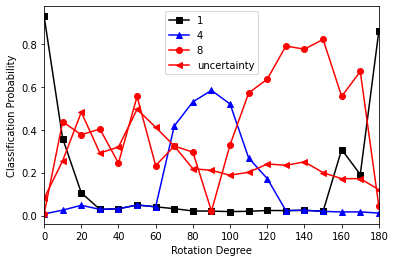

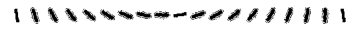

In [37]:
print(u)
rotating_image_classification(x_train[6], sess2, prob2, X2, keep_prob2, u)

## Using the Expected Cross Entropy  (Eq. 4)

In this section, we train neural network using the loss function described in Eq. 4 in the paper. This loss function is derived using the expected value of the cross entropy loss over the predicted Dirichlet distribution.

In [27]:
def loss_EDL(func=tf.digamma):
    def loss_func(p, alpha, global_step, annealing_step): 
        S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
        E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
        annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
    
        alp = E*(1-p) + 1 
        B =  annealing_coef * KL(alp)
    
        return (A + B)
    return loss_func

In [28]:
g3, step3, X3, Y3, annealing_step3, keep_prob3, prob3, acc3, loss3, u3, evidence3, \
    mean_ev3, mean_ev_succ3, mean_ev_fail3 = LeNet_EDL(exp_evidence, loss_EDL(tf.digamma), lmb=0.001)

In [29]:
sess3 = tf.Session(graph=g3)
with g3.as_default():
    sess3.run(tf.global_variables_initializer())

In [30]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L3_train_acc1=[]
L3_train_ev_s=[]
L3_train_ev_f=[]
L3_test_acc1=[]
L3_test_ev_s=[]
L3_test_ev_f=[]
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X3:data, Y3:label, keep_prob3:.5, annealing_step3:10*n_batches}
        sess3.run(step3,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail = sess3.run([acc3,mean_ev_succ3,mean_ev_fail3], feed_dict={X3:mnist.train.images,Y3:mnist.train.labels,keep_prob3:1.})
    test_acc, test_succ, test_fail = sess3.run([acc3,mean_ev_succ3,mean_ev_fail3], feed_dict={X3:mnist.test.images,Y3:mnist.test.labels,keep_prob3:1.})
    
    L3_train_acc1.append(train_acc)
    L3_train_ev_s.append(train_succ)
    L3_train_ev_f.append(train_fail)
    
    L3_test_acc1.append(test_acc)
    L3_test_ev_s.append(test_succ)
    L3_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

epoch 1 - 100%) training: 0.9474 (1317.5409 - 21.8451) 	 testing: 0.9521 (1321.5043 - 19.0664)
epoch 2 - 100%) training: 0.9708 (2343.5542 - 16.1153) 	 testing: 0.9729 (2396.9514 - 13.3511)
epoch 3 - 100%) training: 0.9782 (3687.4148 - 12.7897) 	 testing: 0.9792 (3782.3994 - 10.8410)
epoch 4 - 100%) training: 0.9806 (4667.1011 - 9.3987) 	 testing: 0.9815 (4818.1201 - 7.5895)
epoch 5 - 100%) training: 0.9847 (6145.2998 - 8.8642) 	 testing: 0.9843 (6360.4268 - 8.1370)
epoch 6 - 100%) training: 0.9854 (6633.3608 - 7.2018) 	 testing: 0.9855 (6954.3872 - 8.9421)
epoch 7 - 100%) training: 0.9874 (6864.7080 - 5.0265) 	 testing: 0.9865 (7128.8394 - 5.8941)
epoch 8 - 100%) training: 0.9877 (8757.9004 - 7.5037) 	 testing: 0.9865 (9032.2881 - 9.3263)
epoch 9 - 100%) training: 0.9879 (8522.9375 - 4.1115) 	 testing: 0.9874 (8837.1475 - 7.4968)
epoch 10 - 100%) training: 0.9884 (7080.7183 - 3.3795) 	 testing: 0.9877 (7398.4717 - 7.2527)
epoch 11 - 100%) training: 0.9901 (9605.0977 - 3.3287) 	 testin

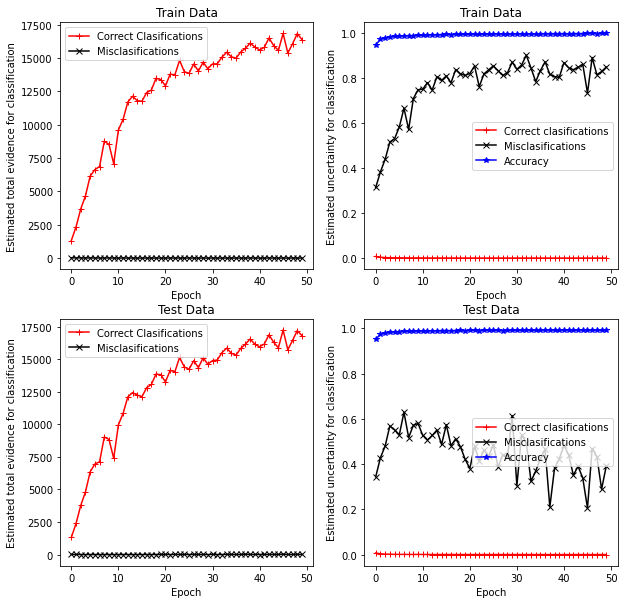

In [31]:
draw_EDL_results(L3_train_acc1, L3_train_ev_s, L3_train_ev_f, L3_test_acc1, L3_test_ev_s, L3_test_ev_f)

The figure above indicates that the neural network generates much more evidence for the correctly classified samples. As a result, it has a very low uncertainty (around zero) for the correctly classified samples, while the uncertainty is very high (around 0.7) for the misclassified samples.

uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[4.5405064e-05 9.9959159e-01 4.5381388e-05 4.5381388e-05 4.5383735e-05
  4.5407662e-05 4.5382989e-05 4.5382403e-05 4.5381388e-05 4.5387354e-05]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[4.5393554e-05 9.9959159e-01 4.5381388e-05 4.5381388e-05 4.5381490e-05
  4.5402445e-05 4.5381388e-05 4.5381388e-05 4.5382101e-05 4.5385044e-05]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[4.5409070e-05 9.9959141e-01 4.5381377e-05 4.5393979e-05 4.5381377e-05
  4.5582172e-05 4.5381377e-05 4.5381377e-05 4.5392993e-05 4.5397381e-05]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.00134553 0.9878646  0.00134566 0.001349   0.00134679 0.00136083
  0.00134549 0.00134547 0.00135081 0.00134577]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.06170092 0.43556845 0.06183429 0.06412706 0.06231331 0.06502452
  0.06171393 0.06174703 0.06426025 0.06171015]]
uncert Tensor("truediv_1:0", shape=(?, 1

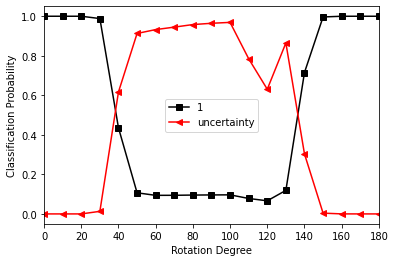

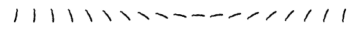

In [32]:
rotating_image_classification(digit_one, sess3, prob3, X3, keep_prob3, u3)

In [33]:
## Using Negative Log of the Expected Likelihood (Eq. 3)

In this section, we repeat our experiments using the loss function based on Eq. 3 in the paper.

In [34]:
g4, step4, X4, Y4, annealing_step4, keep_prob4, prob4, acc4, loss4, u4, evidence4, \
    mean_ev4, mean_ev_succ4, mean_ev_fail4 = LeNet_EDL(exp_evidence, loss_EDL(tf.log), lmb=0.001)

In [35]:
sess4 = tf.Session(graph=g4)
with g4.as_default():
    sess4.run(tf.global_variables_initializer())

In [36]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L4_train_acc1=[]
L4_train_ev_s=[]
L4_train_ev_f=[]
L4_test_acc1=[]
L4_test_ev_s=[]
L4_test_ev_f=[]
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X4:data, Y4:label, keep_prob4:.5, annealing_step4:10*n_batches}
        sess4.run(step4,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail = sess4.run([acc4,mean_ev_succ4,mean_ev_fail4], feed_dict={X4:mnist.train.images,Y4:mnist.train.labels,keep_prob4:1.})
    test_acc, test_succ, test_fail = sess4.run([acc4,mean_ev_succ4,mean_ev_fail4], feed_dict={X4:mnist.test.images,Y4:mnist.test.labels,keep_prob4:1.})
    
    L4_train_acc1.append(train_acc)
    L4_train_ev_s.append(train_succ)
    L4_train_ev_f.append(train_fail)
    
    L4_test_acc1.append(test_acc)
    L4_test_ev_s.append(test_succ)
    L4_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

epoch 1 - 100%) training: 0.9309 (2165.0554 - 36.5399) 	 testing: 0.9392 (2181.9290 - 21.8323)
epoch 2 - 100%) training: 0.9688 (3884.7705 - 21.5658) 	 testing: 0.9709 (3883.1082 - 14.5800)
epoch 3 - 100%) training: 0.9781 (4361.2319 - 13.3693) 	 testing: 0.9779 (4418.8926 - 9.0828)
epoch 4 - 100%) training: 0.9827 (5533.3276 - 10.0886) 	 testing: 0.9833 (5713.2383 - 7.5627)
epoch 5 - 100%) training: 0.9826 (6867.8911 - 14.9795) 	 testing: 0.9819 (7053.1826 - 10.3191)
epoch 6 - 100%) training: 0.9855 (6835.5659 - 7.8734) 	 testing: 0.9856 (7057.7988 - 6.4705)
epoch 7 - 100%) training: 0.9868 (8443.3145 - 6.0136) 	 testing: 0.9859 (8721.5811 - 7.2705)
epoch 8 - 100%) training: 0.9868 (8573.2100 - 8.4309) 	 testing: 0.9854 (8847.8281 - 12.9115)
epoch 9 - 100%) training: 0.9885 (9427.9150 - 4.5519) 	 testing: 0.9877 (9624.7168 - 7.0141)
epoch 10 - 100%) training: 0.9885 (9410.4531 - 2.6497) 	 testing: 0.9864 (9617.1924 - 4.8452)
epoch 11 - 100%) training: 0.9900 (10931.7578 - 3.4179) 	 te

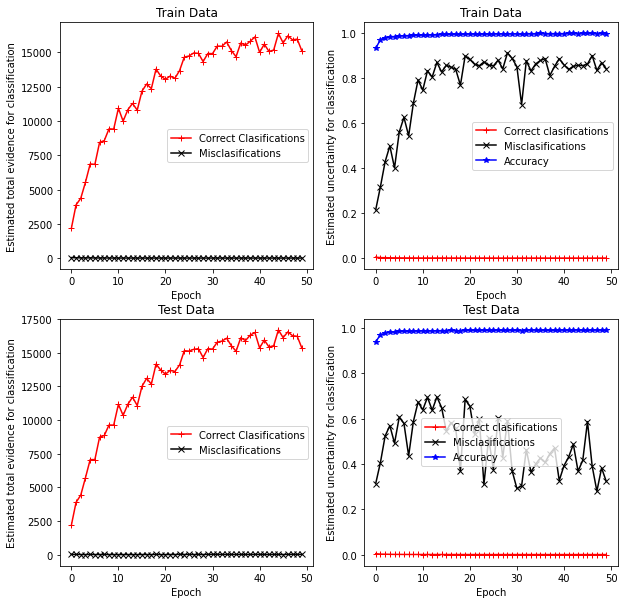

In [37]:
draw_EDL_results(L4_train_acc1, L4_train_ev_s, L4_train_ev_f, L4_test_acc1, L4_test_ev_s, L4_test_ev_f)

uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[1.18707074e-04 9.98931944e-01 1.18629141e-04 1.18629141e-04
  1.18800446e-04 1.18646407e-04 1.18633470e-04 1.18629141e-04
  1.18788856e-04 1.18629141e-04]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.00099892 0.99100864 0.00099846 0.00099853 0.00099931 0.00099865
  0.00099853 0.00099846 0.00100198 0.00099851]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.0014181  0.9872373  0.001417   0.00141791 0.00141856 0.00141825
  0.00141705 0.00141693 0.00142188 0.0014171 ]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.01526079 0.8623015  0.01524654 0.01537034 0.01531436 0.01528086
  0.01524493 0.01524112 0.01545116 0.01528835]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.08312199 0.23889194 0.08366562 0.08511512 0.08401343 0.08365873
  0.08306473 0.08314334 0.09212334 0.08320179]]
uncert Tensor("truediv_1:0", shape=(?, 1), dtype=float32)
[[0.09322473 0.1057125  0.0965

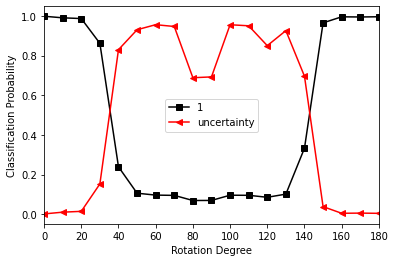

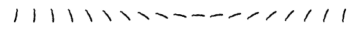

In [38]:
rotating_image_classification(digit_one, sess4, prob4, X4, keep_prob4, u4)

# Some Other Data Uncertainty Experiments

Consider the case that we mix two digits from the MNIST dataset and query a classifier trained on MNIST dataset to classify it. For example, the following image is created by overlaying digit 0 with digit 6. The resulting image have similarities to both digits but neither 0 nor 6.

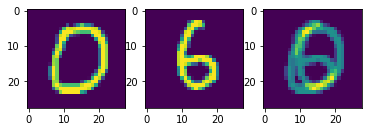

In [39]:
im0 =  mnist.test.images[10]
im6 =  mnist.test.images[21]
img = im0 + im6
img /= img.max()
plt.subplot(1,3,1)
plt.imshow(im0.reshape(28,28))
plt.subplot(1,3,2)
plt.imshow(im6.reshape(28,28))
plt.subplot(1,3,3)
plt.imshow(img.reshape(28,28))
plt.show()

The neural network trained with softmax cross entropy loss has the following prediction for the classification of this image, where the image is classifed as 0 with probability 0.9.

In [40]:
p1 = sess1.run(prob1, feed_dict={X1:img[None,:], keep_prob1:1.0})
print('softmax prob: ', np.round(p1[0], decimals=3))

softmax prob:  [0.682 0.    0.015 0.    0.    0.024 0.271 0.    0.007 0.001]


When we do the same experiments on the neural net trained using the loss function in Eq. 7, we have a much different results. The neural network could not generate any evidence to classify the image into one of 10 digits. Hence, it provides uniform distribution as its prediction. It implies I do not know by providing maximum uncertainty.

In [41]:
uncertainty2, p2 = sess2.run([u, prob2], feed_dict={X2:img[None,:], keep_prob2:1.0})
print('uncertainty:', np.round(uncertainty2[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p2[0], decimals=3))

uncertainty: 0.93
Dirichlet mean:  [0.162 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093]


When we use the loss function in Eq. 5, the exepcted probability is highest for digit 0. It is around 0.32, however, the associated uncertainty is quite high around 0.73 as shown below.

In [42]:
uncertainty3, p3 = sess3.run([u3, prob3], feed_dict={X3:img[None,:], keep_prob3:1.0})
print('uncertainty:', np.round(uncertainty3[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p3[0], decimals=3))

uncertainty: 0.57
Dirichlet mean:  [0.473 0.057 0.058 0.057 0.057 0.059 0.068 0.057 0.057 0.057]


The uncertainty increase to 0.85 while the expected probability for the digit 0 decreases to 0.184 when the loss function in Eq. 6 is used.

In [43]:
uncertainty4, p4 = sess4.run([u4, prob4], feed_dict={X4:img[None,:], keep_prob4:1.0})
print('uncertainty:', np.round(uncertainty4[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p4[0], decimals=3))

uncertainty: 0.31
Dirichlet mean:  [0.719 0.031 0.031 0.031 0.031 0.031 0.033 0.031 0.031 0.031]


Lets try another settings where each of these two digits can be recognizable easily. You can see below an image which is created by combining images for digit 0 and digit 6 without any overlap. 

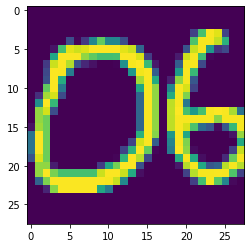

In [44]:
img = np.zeros((28,28))
img[:,:-6] += mnist.test.images[10].reshape(28,28)[:,6:]
img[:,14:] += mnist.test.images[21].reshape(28,28)[:,5:19]
img /= img.max()
plt.imshow(img)
plt.show()

Below, you can see the prediction of the neural network trained with softmax cross entropy for this example. The prediction of the network is digit 2 with probability 0.775. Hence, the network associates quite high probability with the wrong label. 

In [45]:
p1 = sess1.run(prob1, feed_dict={X1:img.reshape(1,-1), keep_prob1:1.0})
print('softmax prob: ', np.round(p1[0], decimals=3))

softmax prob:  [0.    0.006 0.99  0.003 0.001 0.    0.    0.    0.    0.   ]


On the otherhand, when we do the same using the network trained based on the loss in Eq. 7, the output of the neural network is uniform distribution with uncertainty 1.0, as shown below.

In [46]:
uncertainty2, p2 = sess2.run([u, prob2], feed_dict={X2:img.reshape(1,-1), keep_prob2:1.0})
print('uncertainty:', np.round(uncertainty2[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p2[0], decimals=3))

uncertainty: 0.45
Dirichlet mean:  [0.045 0.045 0.599 0.045 0.045 0.045 0.045 0.045 0.045 0.045]


The neural networks, trained using the loss functions defined in Eq. 5 and Eq. 6 in the paper, also have very high uncertainty for their predictions. These networks assing small amount of evidence for the classification of the image as digit 2. However, they associate very high uncertainty with their misclassifications of the image.

In [47]:
uncertainty3, p3 = sess3.run([u3, prob3], feed_dict={X3:img.reshape(1,-1), keep_prob3:1.0})
print('uncertainty:', np.round(uncertainty3[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p3[0], decimals=3))

uncertainty: 0.48
Dirichlet mean:  [0.048 0.048 0.561 0.048 0.048 0.048 0.048 0.058 0.048 0.048]


In [48]:
uncertainty4, p4 = sess4.run([u4, prob4], feed_dict={X4:img.reshape(1,-1), keep_prob4:1.0})
print('uncertainty:', np.round(uncertainty4[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p4[0], decimals=3))

uncertainty: 0.07
Dirichlet mean:  [0.007 0.007 0.94  0.007 0.007 0.007 0.007 0.007 0.007 0.007]
